In [1]:
import torch
import torchvision
import os
import getpass
if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))
print(os.getcwd())
import sys
sys.path.append(os.getcwd())
cwd_path = os.getcwd()

from kornia.geometry.nerf.camera_utils import CameraParser
from kornia.geometry.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

/home/yhollander/Documents/Git/kornia


## Load scene images and plot one of them

torch.Size([756, 1008, 3])

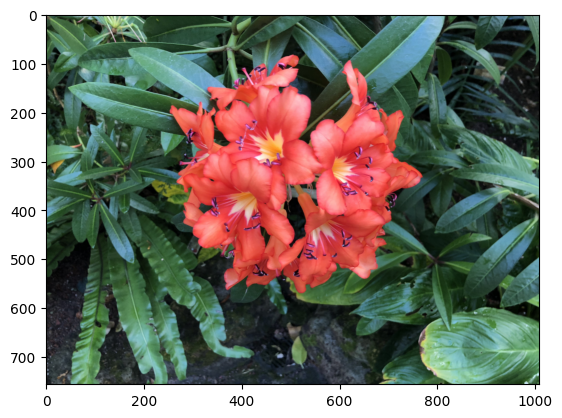

In [2]:
img_paths = glob.glob('kornia/geometry/nerf/kornia_nerf_data/flower_4/images/*.png')

transform = torchvision.transforms.Resize((250))    # In case we want to reduce resolution
imgs: torch.tensor = []
for img_path in img_paths:
    img = read_image(img_path)
    # img = transform(img)  # Uncomment to apply downsizing
    imgs.append(img)

img_plt = torch.permute(imgs[6], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

camera_parser = CameraParser('./test/geometry/nerf/cameras.xml', device=device)
cameras = camera_parser.create_cameras()

cuda


## Run training on image scene

In [4]:
nerf_obj = NerfSolver(device=device)
num_img_rays = 1024
nerf_obj.init_training(cameras=cameras, min_depth=0., max_depth=3., imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=num_img_rays, num_ray_points=51)

In [12]:
nerf_obj.run(num_epochs=5)

Epoch: 0: epoch_psnr = 15.013706166269646


## Rendering novel views

### Sub-set of input cameras

In [13]:
from kornia.geometry.nerf.camera_utils import cameras_for_ids

camera_ids = [2]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [14]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

In [15]:
img_rendered_plt = list(map(lambda img: torch.permute(img, (1, 2, 0)), imgs_rendered))

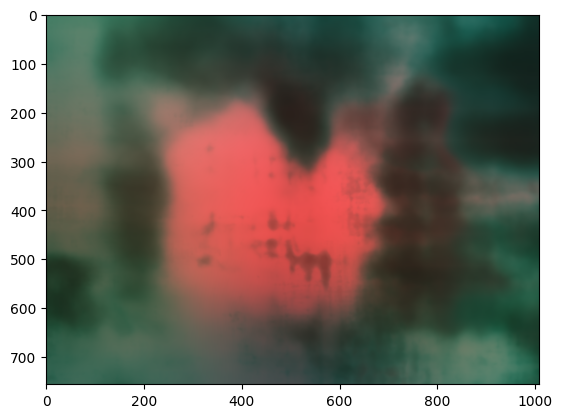

In [16]:
plt.imshow(img_rendered_plt[0])

### Spiral pattern

In [17]:
from kornia.geometry.nerf.camera_utils import create_spiral_path

cameras_spiral = create_spiral_path(cameras, rad=1., num_views=3, num_circles=2)
imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

In [18]:
import numpy as np
import imageio

img_rendered_spiral_disp = [(img_rendered_spiral.permute(1, 2, 0) * 255).cpu().numpy().astype(np.uint8) for 
                            img_rendered_spiral in imgs_rendered_spiral]

dir = 'kornia/geometry/nerf/kornia_nerf_data/flower_4'
scene_name = 'flower_4'
gif_path = os.path.join(dir, scene_name + '_spiral.gif')
imageio.mimwrite(gif_path, img_rendered_spiral_disp, fps=30)

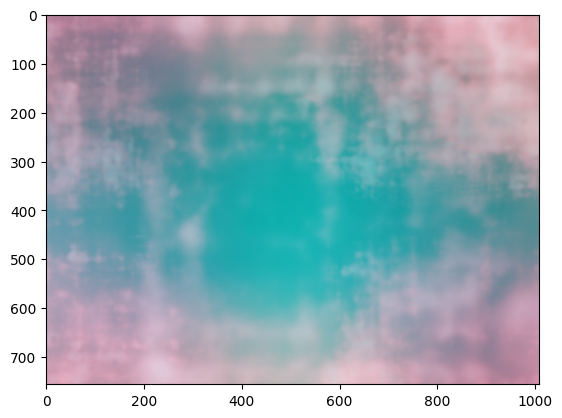

In [19]:
plt.imshow(img_rendered_spiral_disp[0])

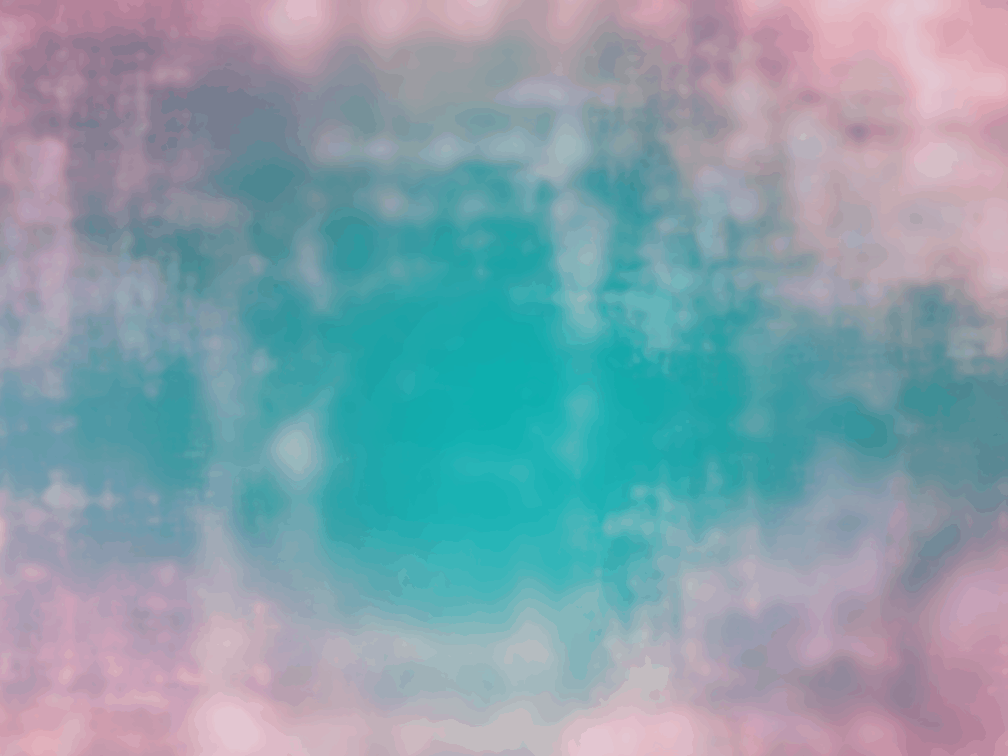

In [20]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())